<a href="https://colab.research.google.com/github/AnandMasurkar/GAN-for-Fashion-design-/blob/master/GAN_for_Generating_Fashion_Designs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN for Generating Fashion Designs

In [0]:
# Check that imports for the rest of the file work.
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)  # Disable noisy outputs.
# Import all the libraries
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape
from keras.models import Model,Sequential
from keras.datasets import fashion_mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam , adam

--------------------
### MNIST DATASET - Fashion images training and testing examples

### Dataset link: https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles

###  We'll use these images to train a GAN to generate fake images of fashion designs. 

### GAN Estimator
TensorFlow's Estimator API that makes it easy to train models. TF-GAN offers GANEstimator, an Estimator for training GANs.

In [0]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [0]:
x_train.shape

(60000, 28, 28)

In [0]:
y_train.shape

(60000,)

In [0]:
x_test.shape

(10000, 28, 28)

In [0]:
y_test.shape

(10000,)

In [0]:
#We next normalize the images
x_train = (x_train.astype(np.float32) - 127.5)/127.5

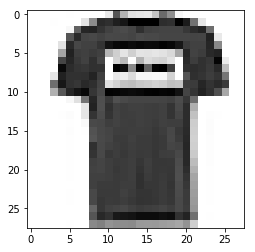

In [0]:
plt.imshow(x_train[1], cmap='Greys')

In [0]:
x_train = np.expand_dims(x_train, axis=3)

In [0]:
# import all required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
def create_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))

  model.summary()

  noise = Input(shape=(100,))
  img = model(noise)

  return Model(noise, img)

generator = create_generator()
z = Input(shape=(100,))
img = generator(z)



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_36 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dense_37 (Dense)             (None, 1024)            

In [0]:
def create_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)

  return Model(img, validity)

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

In [0]:
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [0]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


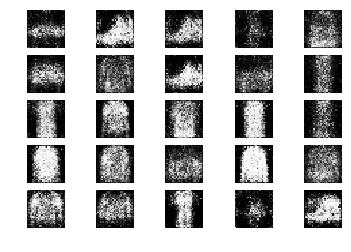

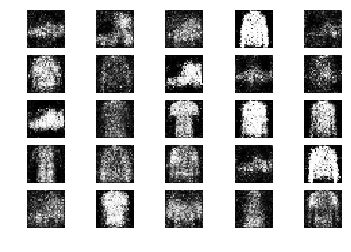

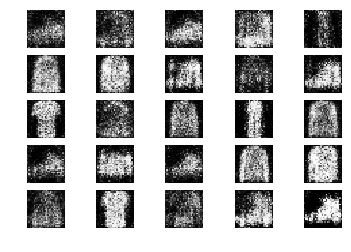

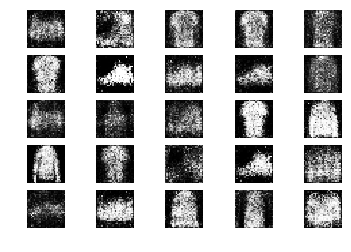

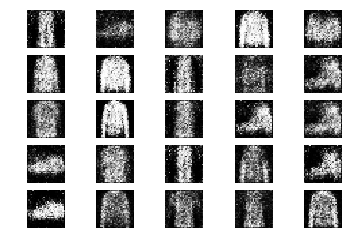

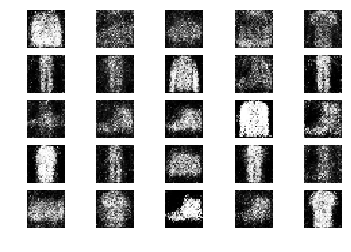

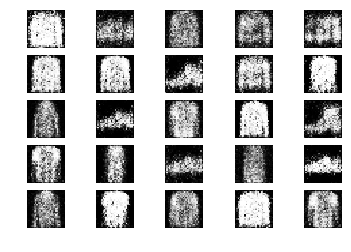

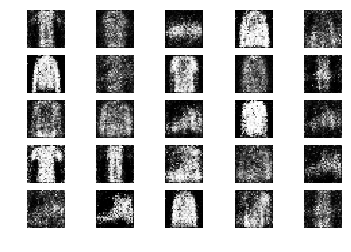

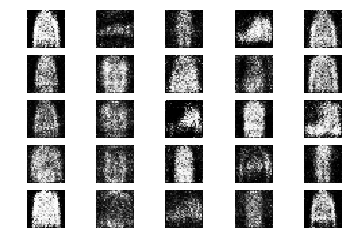

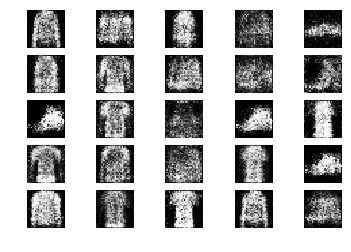

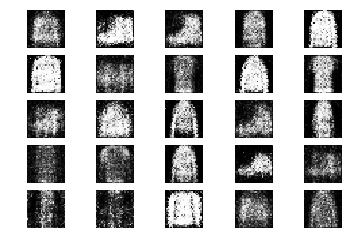

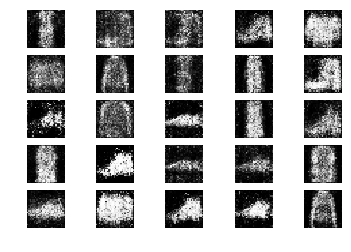

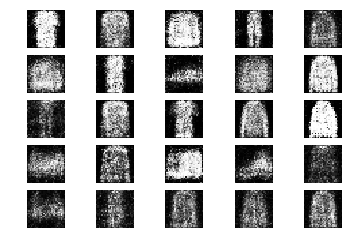

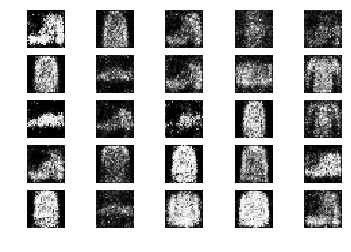

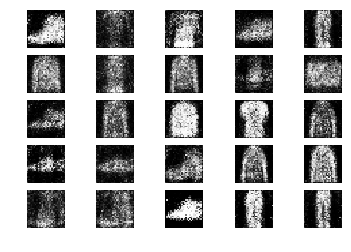

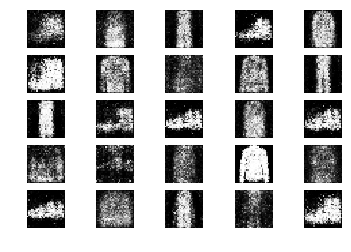

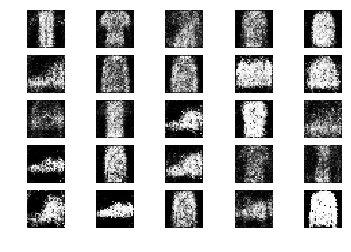

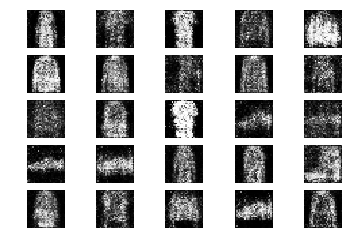

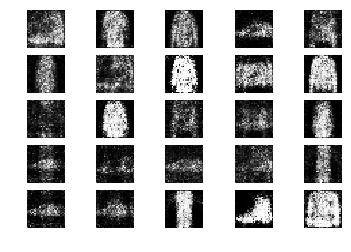

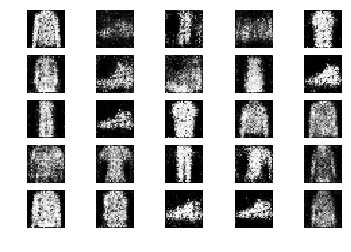

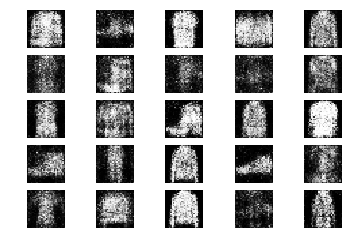

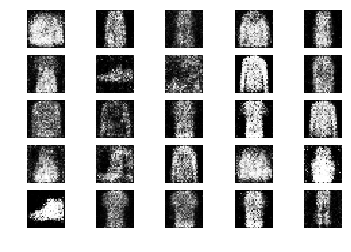

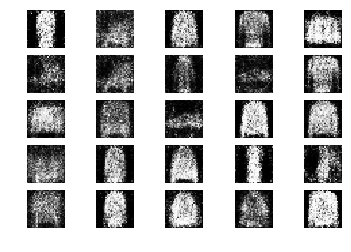

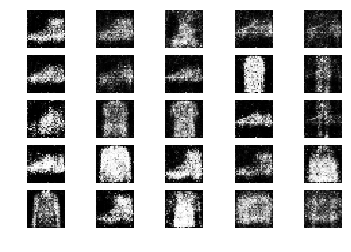

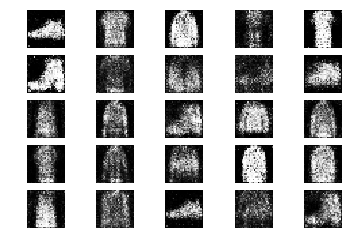

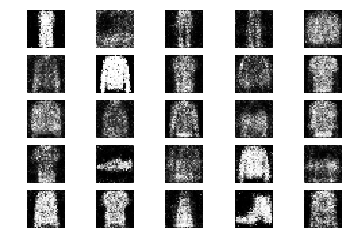

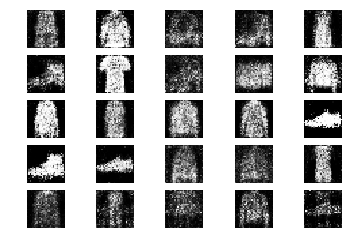

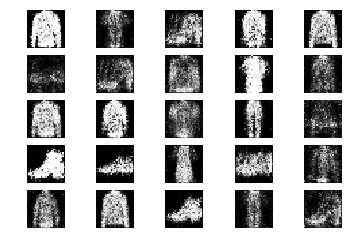

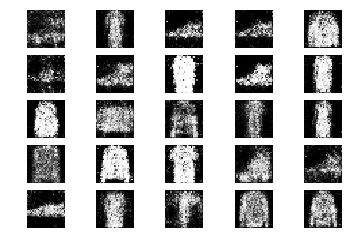

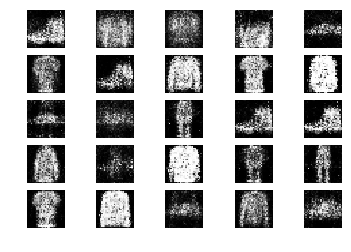

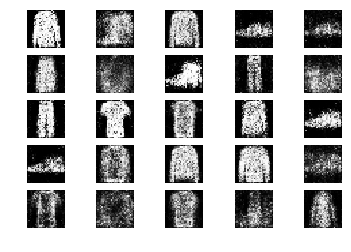

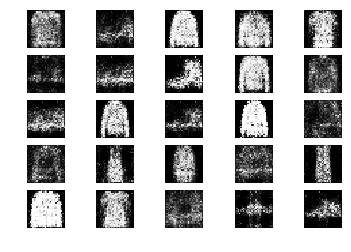

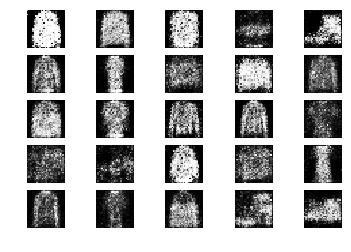

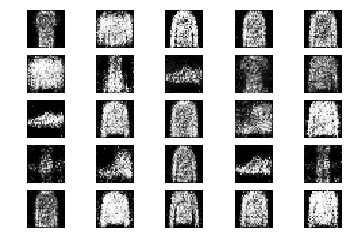

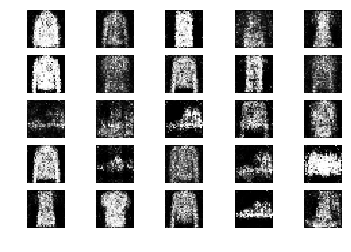

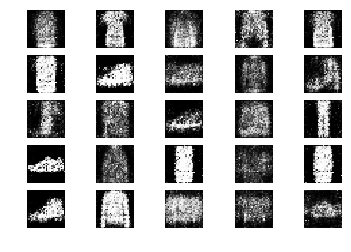

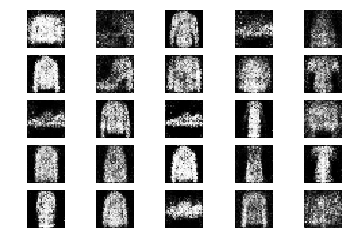

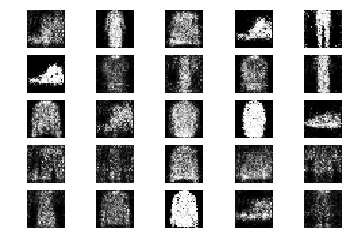

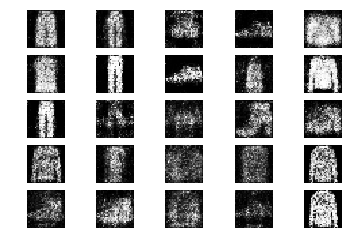

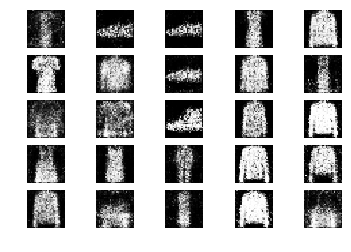

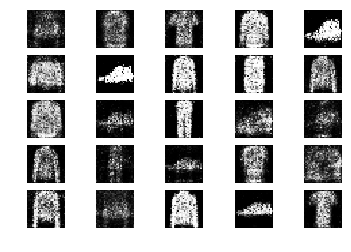

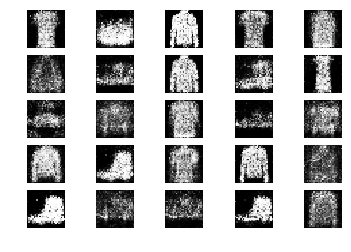

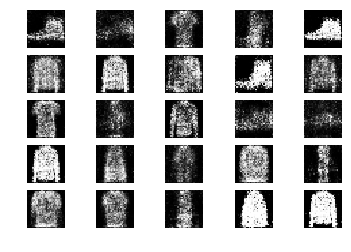

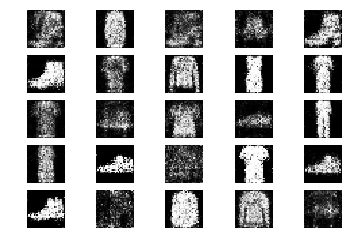

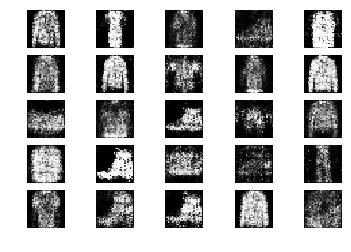

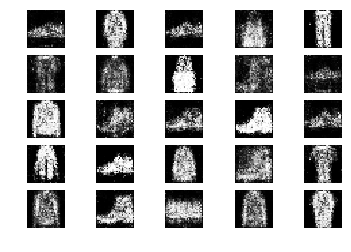

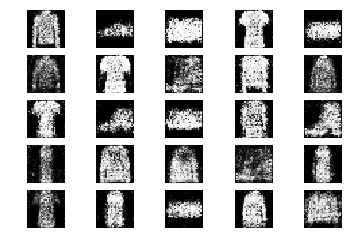

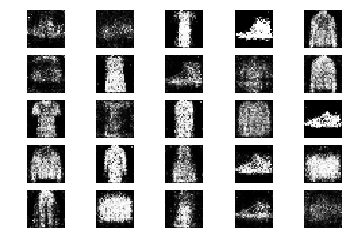

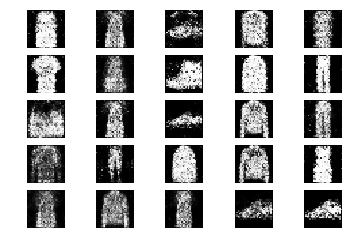

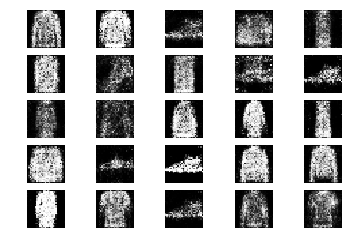

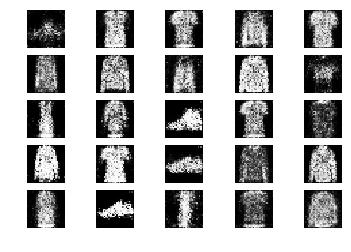

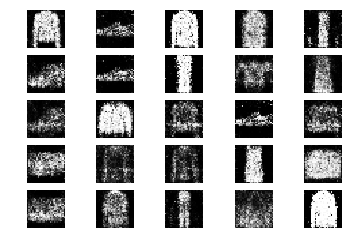

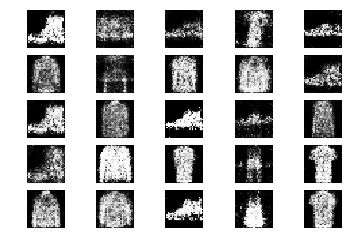

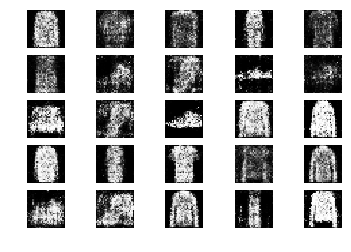

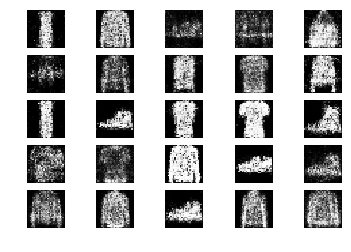

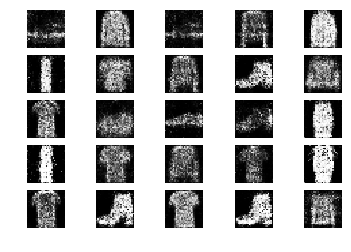

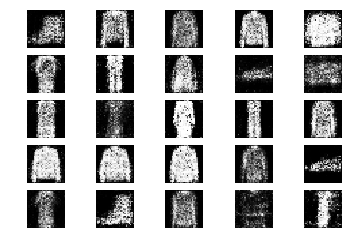

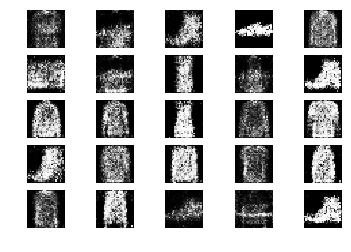

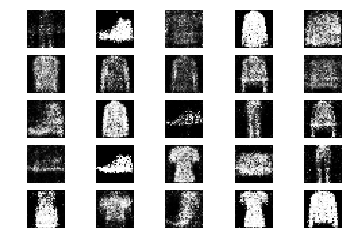

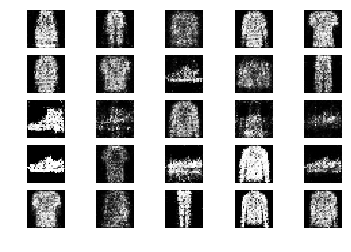

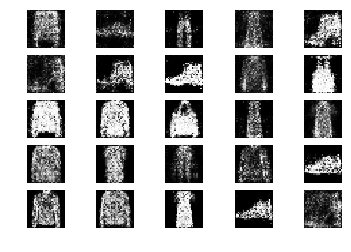

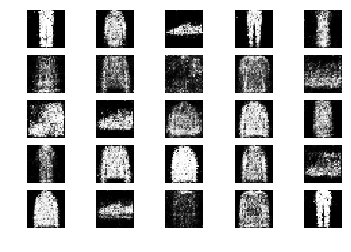

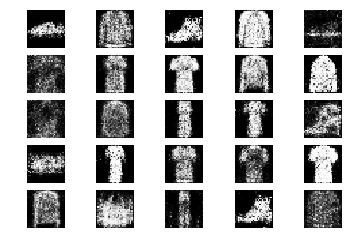

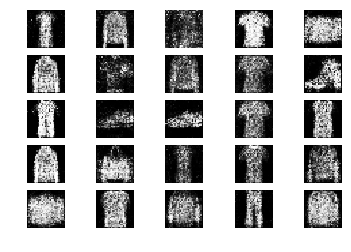

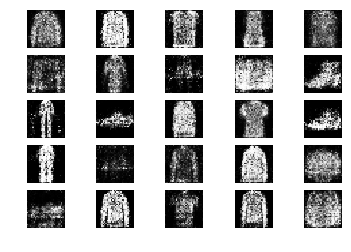

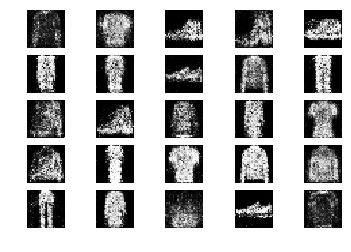

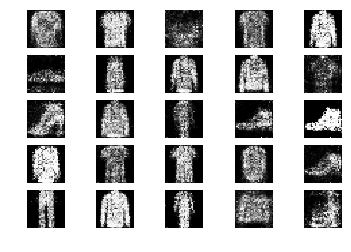

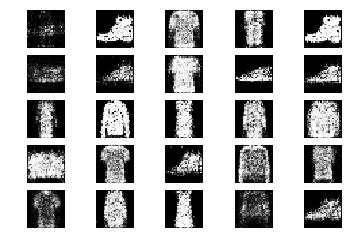

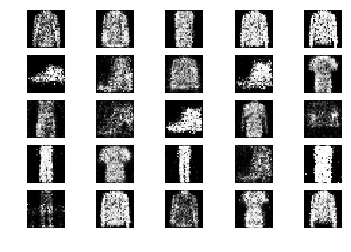

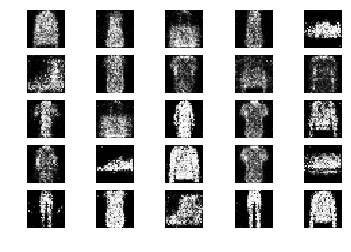

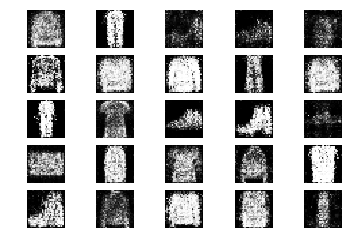

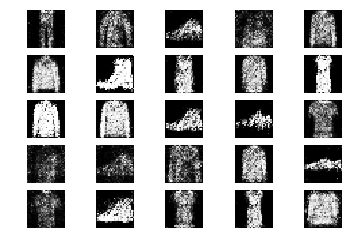

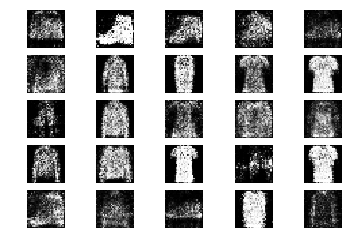

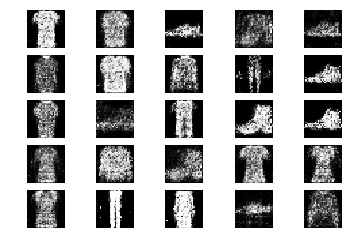

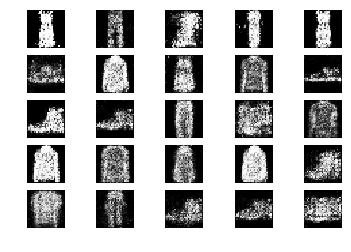

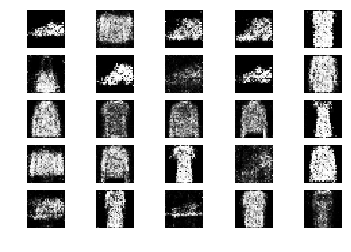

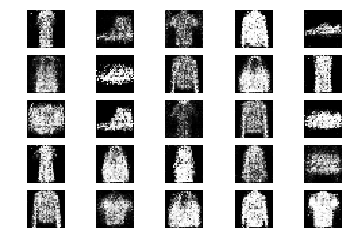

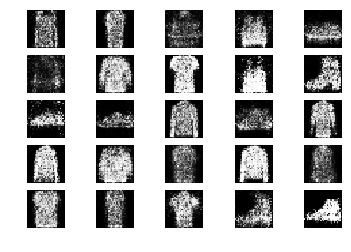

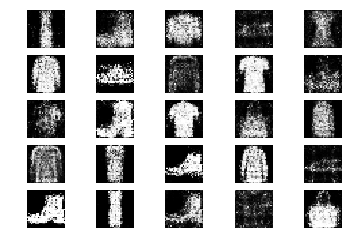

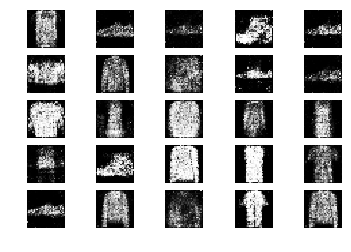

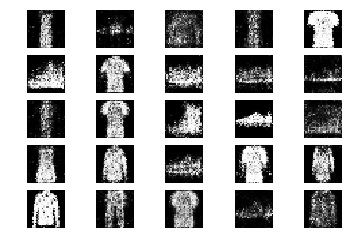

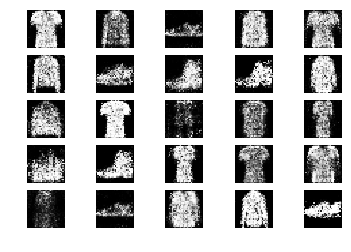

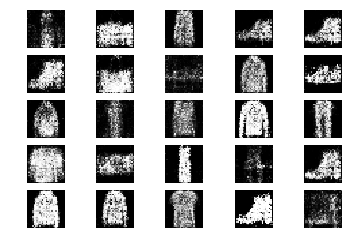

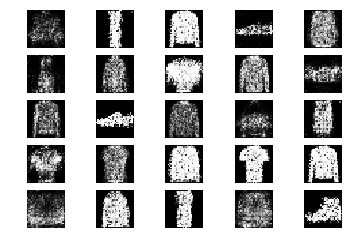

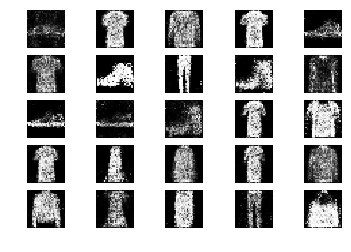

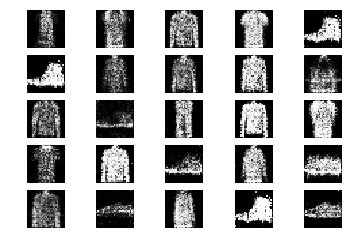

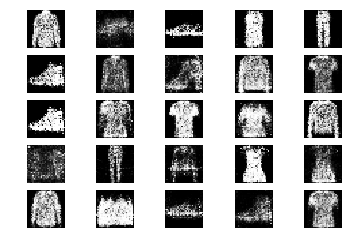

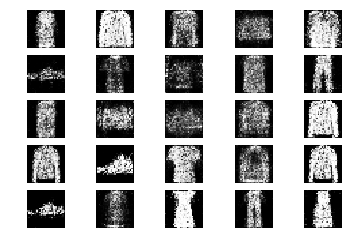

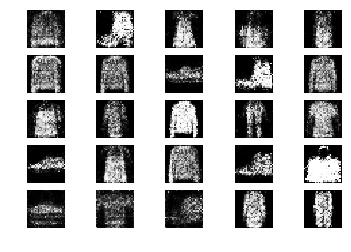

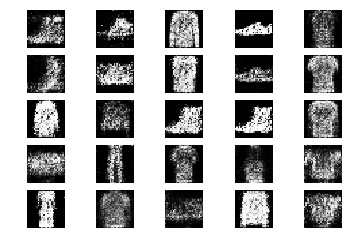

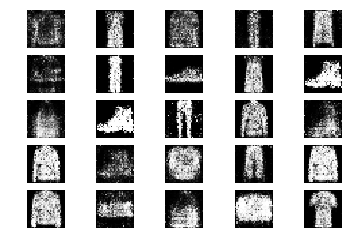

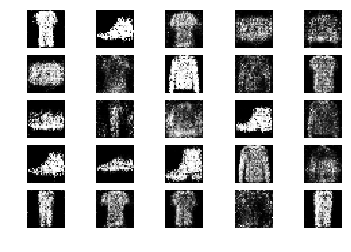

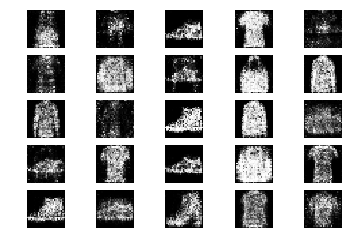

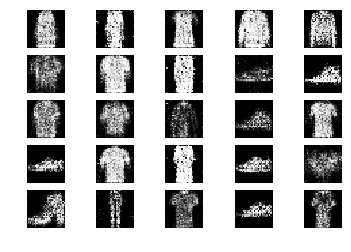

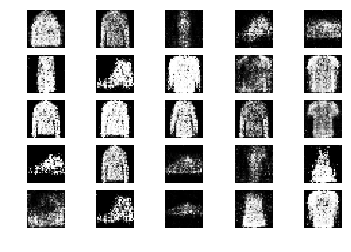

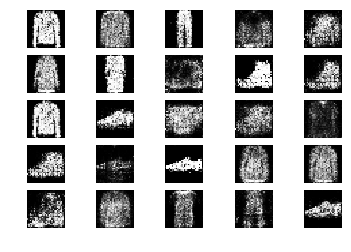

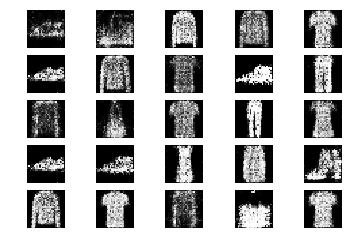

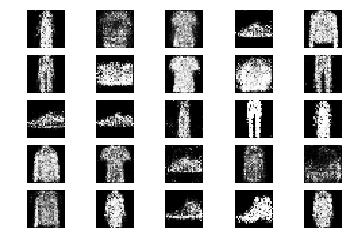

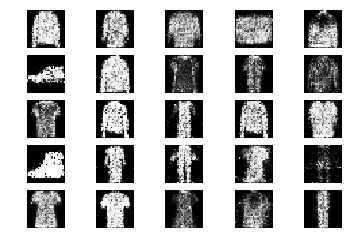

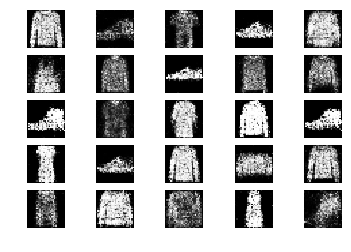

In [0]:
epochs = 5000

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  if epoch % 50 == 0:
    sample_images(epoch)